![title](img/ccfraud.jpg)

## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('white')
import missingno as msno
import warnings
from pyecharts import Pie
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei'] # Default font 
pd.set_option('display.max_columns', 100) # display max columns

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/lml/utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


In [2]:
import missingno as msno
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE
import itertools

In [3]:
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# explore the dataset
print(*df.columns)

Time V1 V2 V3 V4 V5 V6 V7 V8 V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 Amount Class


* The attritbutes are results of PCA transformation for sensistive data security purpose

In [5]:
print(df.shape)

(284807, 31)


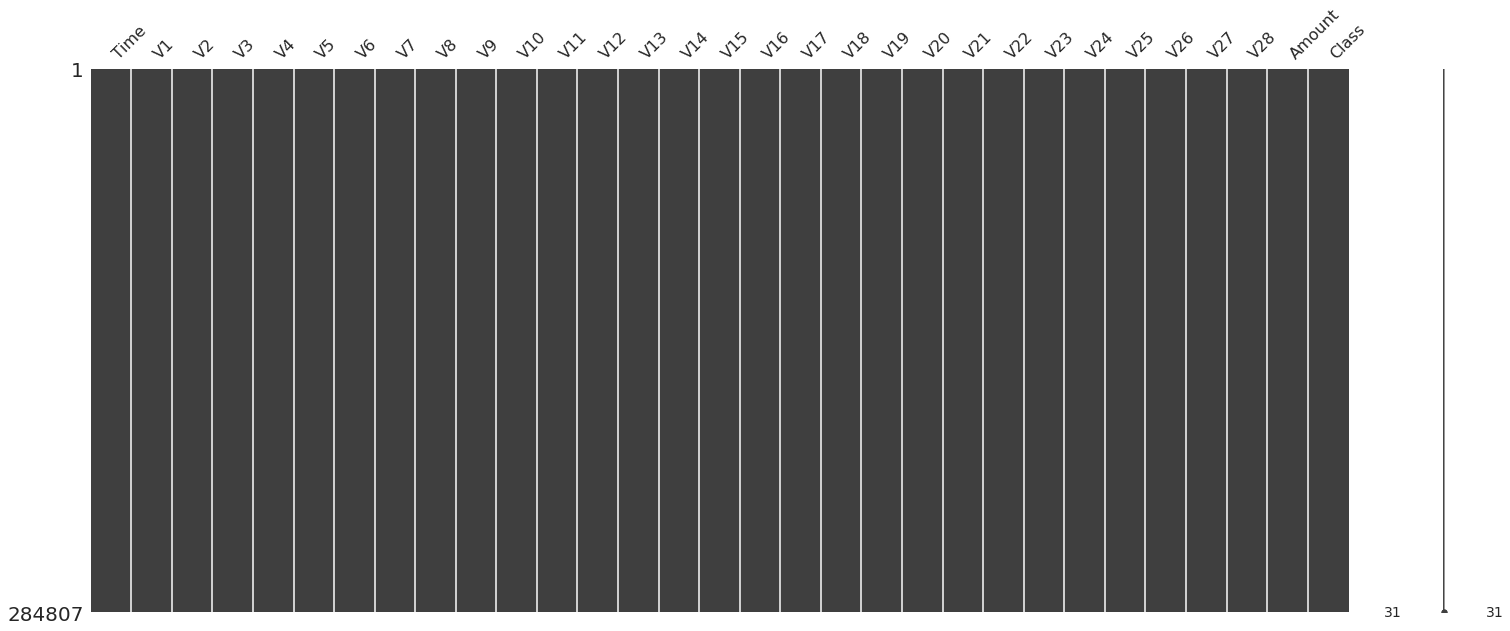

In [6]:
# Check missing value
msno.matrix(df)
plt.show()

### Feature Engineering

In [7]:
### Time is in seconds, Convert time to hour based variable for visualization purpose
df['Hour'] = df['Time'].apply(lambda x: divmod(x, 3600)[0]).astype('int')

In [8]:
# Determine number of fraud cases in dataset
fraud = df[df['Class'] == 1]
valid = df[df['Class'] == 0]

outlier_fraction = len(fraud)/float(len(df))
print('{}%'.format(outlier_fraction * 100))

print('Fraud cases: {}'.format(len(fraud)))
print('Valid cases: {}'.format(len(valid)))

0.1727485630620034%
Fraud cases: 492
Valid cases: 284315


In [9]:
count = df['Class'].value_counts().tolist()
attr = ['Non-Fraud', 'Fraud']
pie = Pie('', title_pos = '30%', width = 800)
pie.add('', attr, count, is_label_show = True, legend_orient = 'vertical', legend_pos = '80%')
pie

### Check correlation between variables in each class

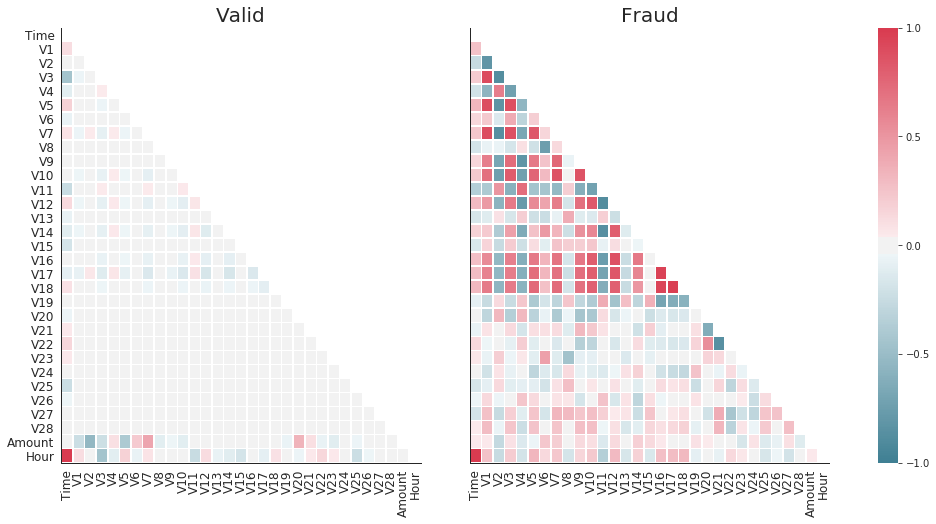

In [10]:
corr_valid = valid.loc[:, valid.columns != 'Class'].corr()
corr_fraud = fraud.loc[:, fraud.columns != 'Class'].corr()

# Mask for displaying only lower triangle
mask = np.zeros_like(corr_valid)
indices = np.triu_indices_from(corr_valid)
mask[indices] = True

grid_kws = {'width_ratios':(0.9, 0.9, 0.05), 'wspace': 0.2}

fig, (ax_valid, ax_fraud, cbar_ax) = plt.subplots(1, 3, gridspec_kw = grid_kws, figsize = (15,8))

cmap = sns.diverging_palette(220, 8, as_cmap = True)

ax_valid = sns.heatmap(corr_valid, ax = ax_valid, vmin = -1, vmax = 1, cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax_valid.set_xticklabels(ax_valid.get_xticklabels(), size = 12)
ax_valid.set_yticklabels(ax_valid.get_yticklabels(), size = 12)
ax_valid.set_title('Valid', size = 20)

ax_fraud = sns.heatmap(corr_fraud, ax = ax_fraud, vmin = -1, vmax = 1, cmap = cmap, square = False, linewidths = 0.5, mask = mask, yticklabels = False, 
                       cbar_ax = cbar_ax, cbar_kws = {'orientation':'vertical','ticks':[-1,-0.5,0,0.5,1]})

ax_fraud.set_xticklabels(ax_fraud.get_xticklabels(), size = 12)
ax_fraud.set_title('Fraud', size = 20)

sns.despine()
plt.tight_layout()
plt.show()

* As we can see, the correlation between variables is stronger for fraud class as compared to valid classes.

#### Transaction frequency and amount

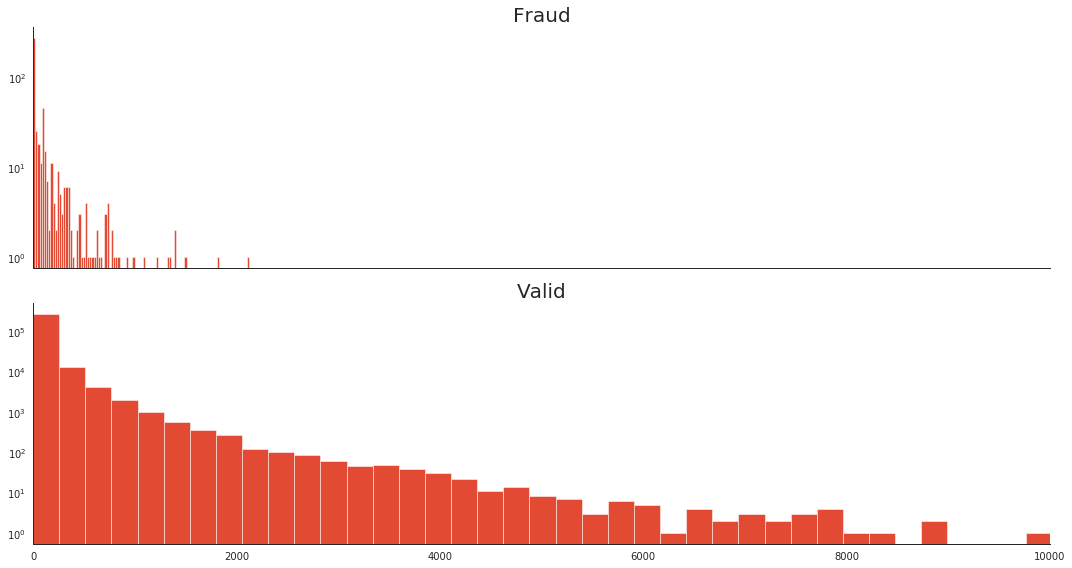

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (15,8))

bins = 100

ax1.hist(fraud['Amount'], bins = bins)
ax1.set_title('Fraud', size = 20)
ax1.set_yscale('log')

ax2.hist(valid['Amount'], bins = bins)
ax2.set_title('Valid', size = 20)
ax2.set_yscale('log')

plt.xlim(0,10000)

sns.despine()
plt.tight_layout()
plt.show()

In [12]:
round(df.groupby('Class').Amount.agg({'count':'count','mean':'mean',
                                'mininum':'min','maximum':'max',
                                'std':'std'}).reset_index(),2)

,Class,count,mean,mininum,maximum,std
0,0,284315,88.29,0.0,25691.16,250.11
1,1,492,122.21,0.0,2125.87,256.68


* Fradulent classes tend to centered around smaller amount of transactions whereas valid amount is spreaded.
* The maximum amount of fraudulent transaction is 2125.87, which is still considered a small amount.
* The minimum amount for both valid and fraud transaction is 0, which needs further investigation

#### Transaction amount == 0

In [13]:
df[df.Amount == 0].Class.value_counts()

0    1798
1      27
Name: Class, dtype: int64

* There are 1798 and 27 transactions with 0 amount in valid and fraud respectively. While if the transaction amount is zero, it is not count toward a **effective** transaction, these rows are removed from the dataframe.

In [14]:
df = df[df.Amount != 0]

In [15]:
print('There are {} rows and {} columns left in the dataframe'.format(df.shape[0],df.shape[1]))

There are 282982 rows and 32 columns left in the dataframe


#### Transaction frequency and transaction time

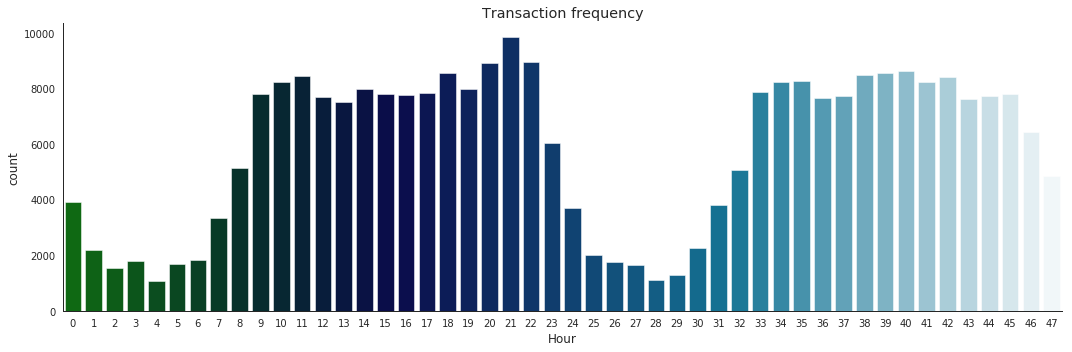

In [16]:
fig, axes = plt.subplots(figsize = (15,5))

sns.countplot(df['Hour'], palette = 'ocean')

plt.title('Transaction frequency')

sns.despine()
plt.tight_layout()
plt.show()

* Most transaction occur between 9am in the morning to 10pm at night

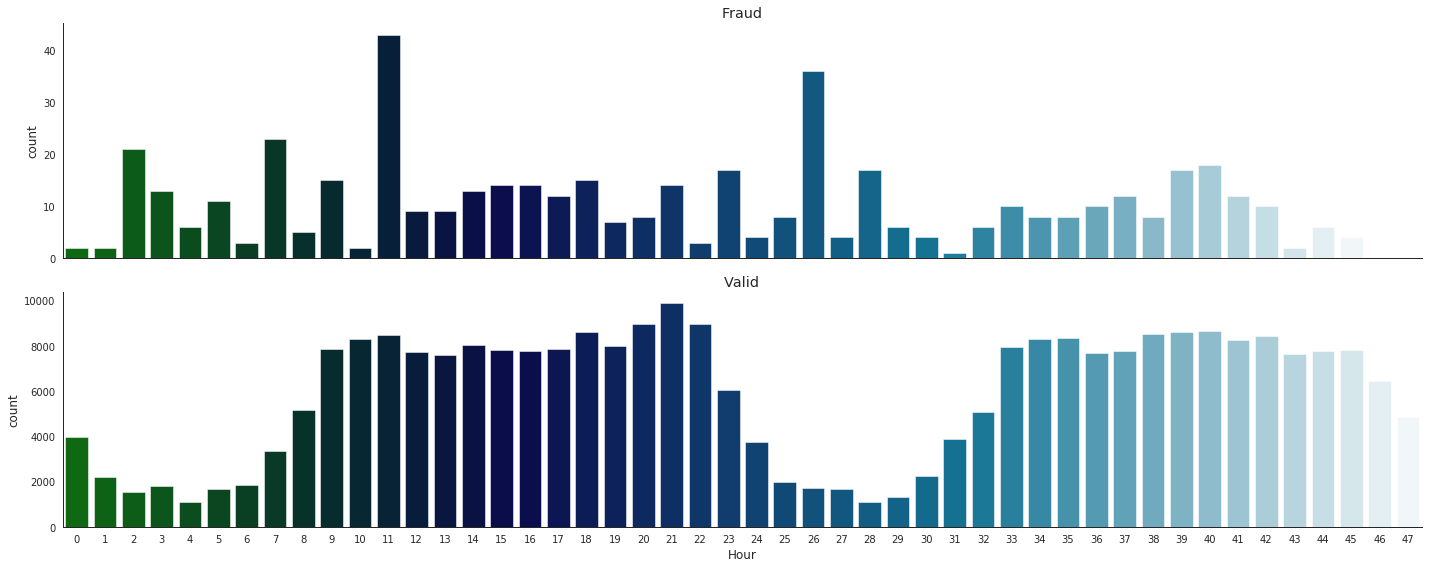

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (20,8))

ax1 = sns.countplot(x = 'Hour', data = fraud, palette = 'ocean', ax = ax1)
ax1.set_title('Fraud')
ax1.set_xlabel('')

ax2 = sns.countplot(x = 'Hour', data = valid, palette = 'ocean', ax = ax2)
ax2.set_title('Valid')

sns.despine()
plt.tight_layout()
plt.show()

* At 11 am in the morning, the most number of fraud transactions (43) occurs. The rest occures in between 9pm in the after to 11 am. Fraudulent activity tends to happen during rest time to avoid attention.

#### Transaction amount and time

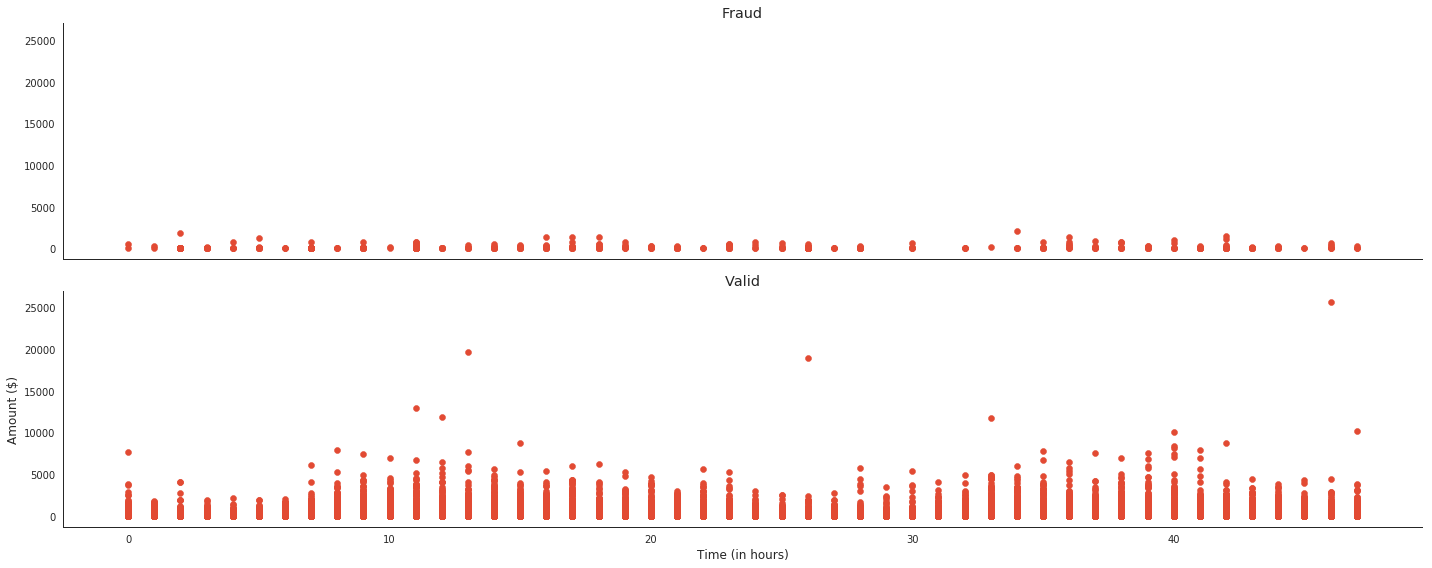

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (20,8))

ax1.scatter(fraud['Hour'], fraud['Amount'])
ax1.set_title('Fraud')

ax2.scatter(valid['Hour'], valid['Amount'])
ax2.set_title('Valid')

plt.xlabel('Time (in hours)')
plt.ylabel('Amount ($)')

sns.despine()
plt.tight_layout()
plt.show()

### Further analysis on time

In [19]:
def convert_hour(x):
    return x - 24 if x >= 24 else x

In [20]:
valid['Hour2'] = valid['Hour'].apply(convert_hour)
fraud['Hour2'] = fraud['Hour'].apply(convert_hour)

In [21]:
df['Hour2'] = df['Hour'].apply(convert_hour)

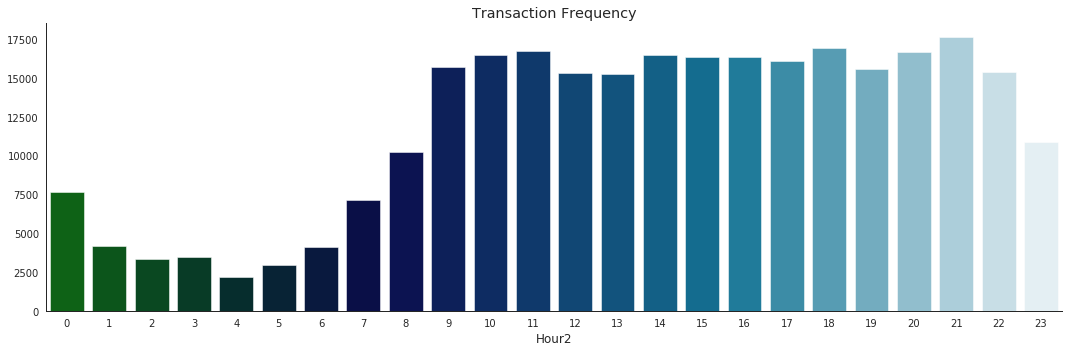

In [22]:
fig, axes = plt.subplots(figsize = (15,5))

sns.countplot(df['Hour2'], palette = 'ocean')

sns.despine()
plt.ylabel('')
plt.title('Transaction Frequency')
plt.tight_layout()
plt.show()

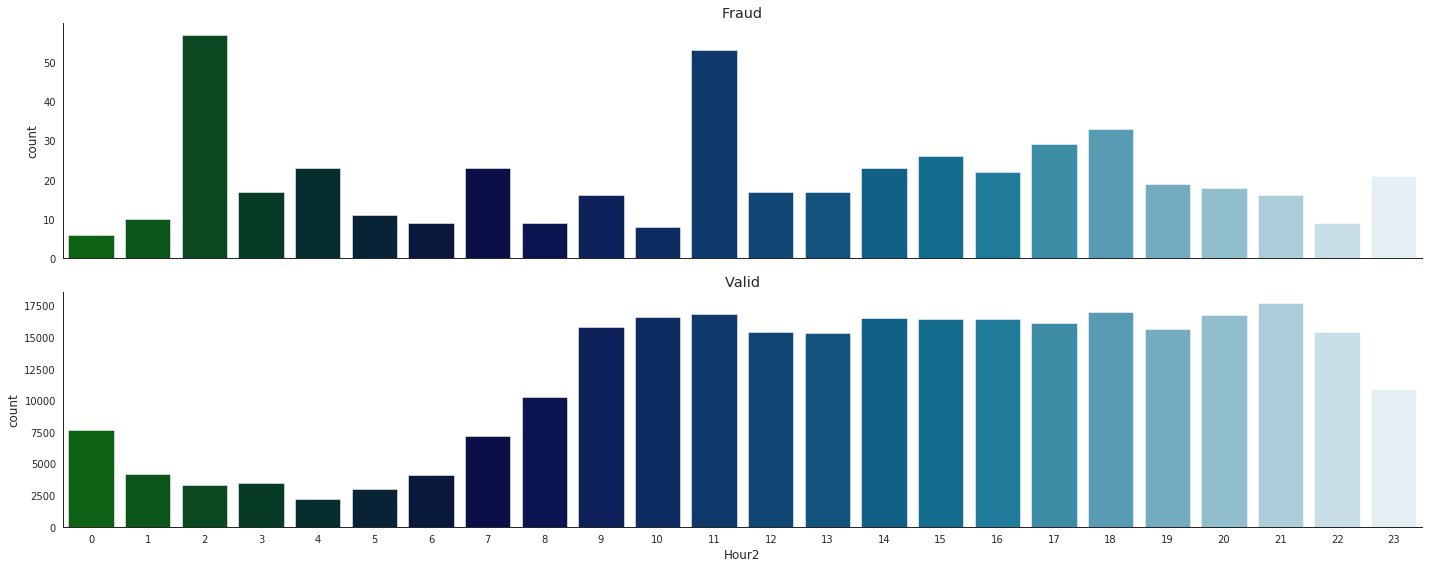

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (20,8))

ax1 = sns.countplot(x = 'Hour2', data = fraud, palette = 'ocean', ax = ax1)
ax1.set_title('Fraud')
ax1.set_xlabel('')

ax2 = sns.countplot(x = 'Hour2', data = valid, palette = 'ocean', ax = ax2)
ax2.set_title('Valid')

sns.despine()
plt.tight_layout()
plt.show()

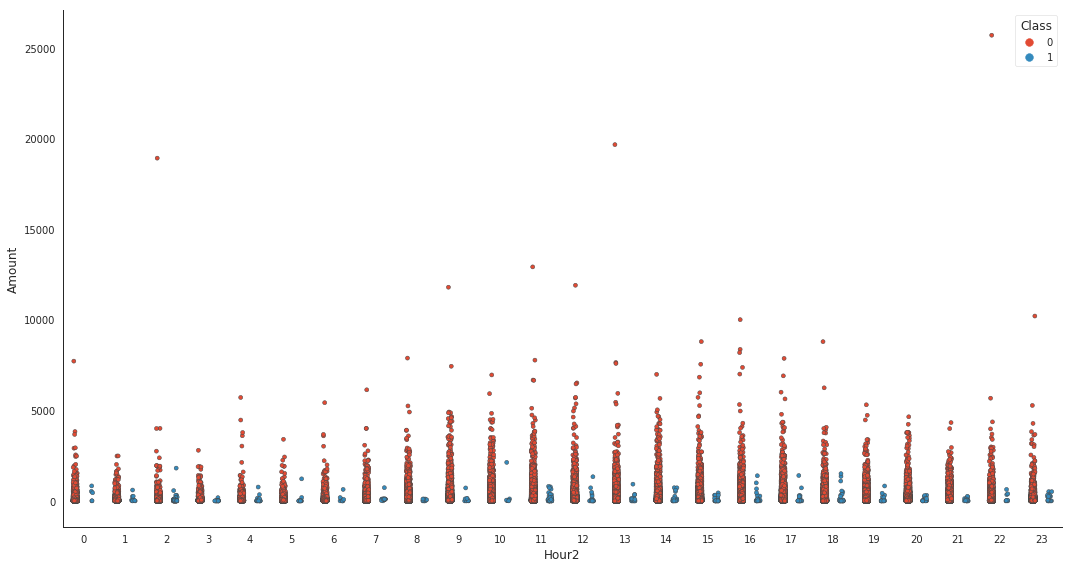

In [24]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.stripplot(x = 'Hour2', y = 'Amount', hue = 'Class', 
                  size = 4, data = df, linewidth = 0.5, jitter = True, dodge = True)

plt.tight_layout()
sns.despine()
plt.show()

### Analysis on each variables

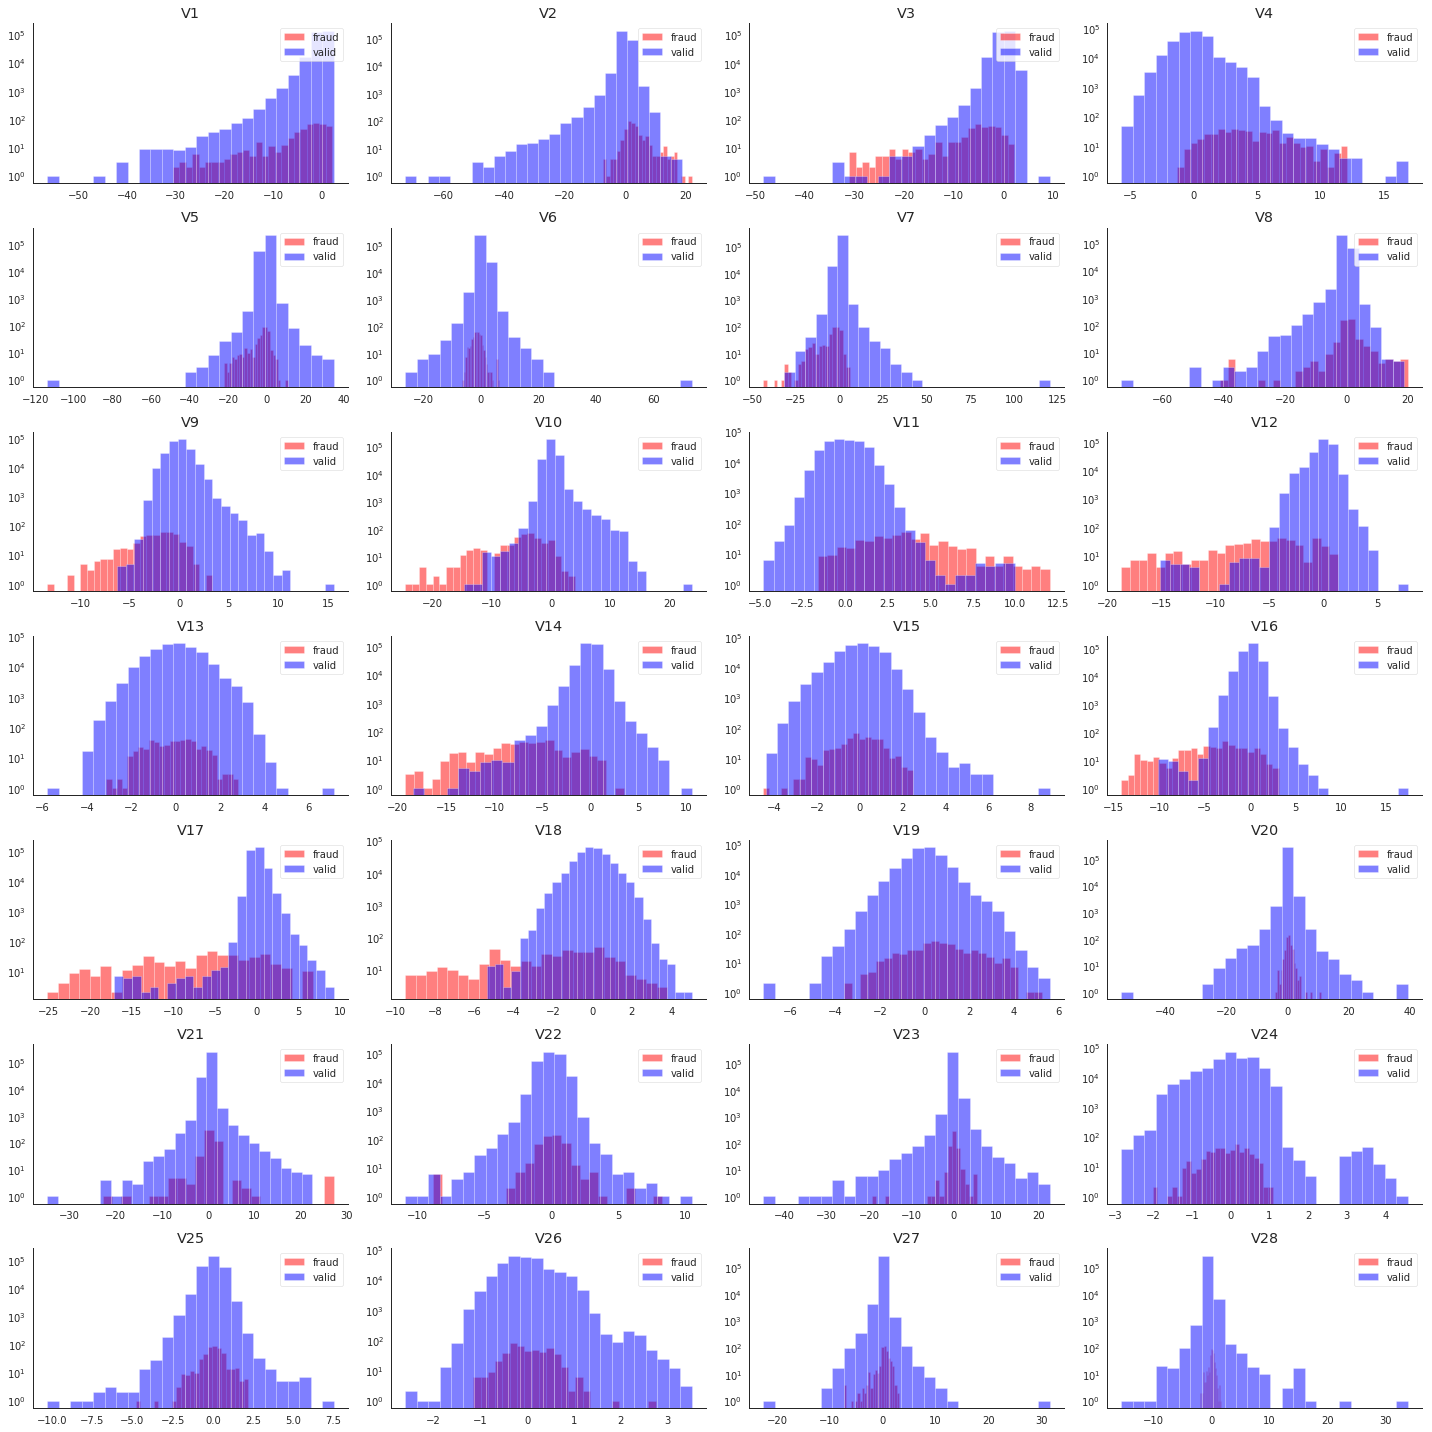

In [25]:
var_list = 'V1 V2 V3 V4 V5 V6 V7 V8 V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28'.split(' ')

fig, axes = plt.subplots(figsize = (20,20))

for i, v in enumerate(var_list):
    plt.subplot(7,4,i+1)
    plt.hist(df[df['Class'] == 1][v], alpha = 0.5, bins = 25, label = 'fraud', color = 'r')
    plt.hist(df[df['Class'] == 0][v], alpha = 0.5, bins = 25, label = 'valid', color = 'b')
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.title(v)

sns.despine()
plt.tight_layout()
plt.show()

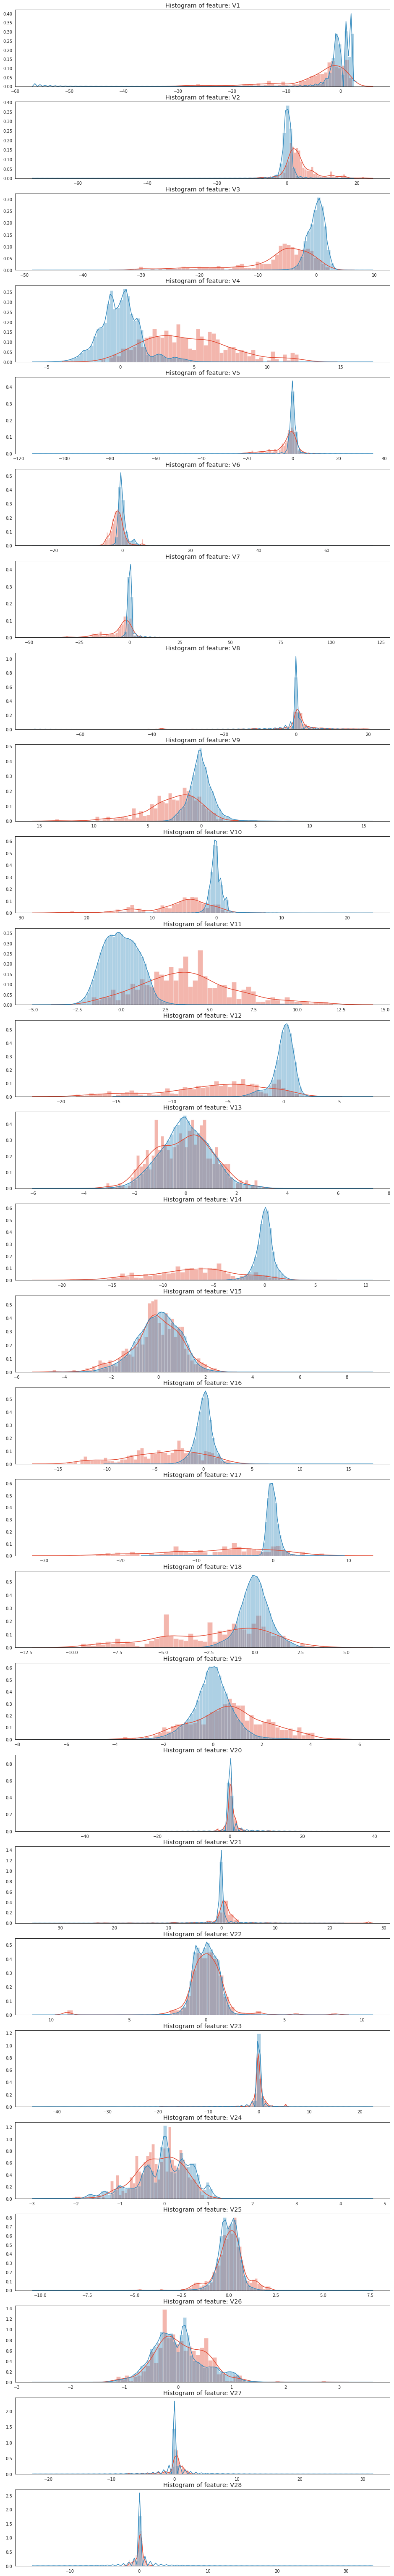

In [26]:
import matplotlib.gridspec as gridspec

v_feat = df.ix[:, 1:29].columns
plt.figure(figsize = (16, 28 * 4))
gs = gridspec.GridSpec(28,1)

for i,cn in enumerate(df[v_feat]):
    ax = plt.subplot(gs[i])
    sns.distplot(fraud[cn], bins = 50)
    sns.distplot(valid[cn], bins = 100)
    ax.set_xlabel('')
    ax.set_title('Histogram of feature: ' + str(cn))
    
plt.show()

* We drop variables that does not show a very different distribution for both class like `V8`,`V13`,`V15`,`V20`,`V21`,`V22`,`V23`,`V24`,`V25`,`V26`,`V28`.

In [27]:
drop_col = ['V8','V13','V15','V20','V21','V22','V23','V24','V25','V26','V28','Time','Hour']
df = df.drop(drop_col, axis = 1)

df.shape

(282982, 20)

In [28]:
print('We drop {} variables from the dataset'.format(len(drop_col)))

We drop 13 variables from the dataset


#### Feature Scaling

In [29]:
col = ['Amount', 'Hour2']

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

df_new = df

df_new[col] = sc.fit_transform(df_new[col])

df_new.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V27,Amount,Class,Hour2
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.133558,0.242005,0,-2.408778
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.008983,-0.343785,0,-2.408778
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,-0.055353,1.155155,0,-2.408778
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,0.062723,0.137868,0,-2.408778
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,0.219422,-0.075469,0,-2.408778


#### Feature importance ranking

In [30]:
X_feature = df_new.columns.tolist()
X_feature.remove('Class')

X = df_new[X_feature]
y = df_new['Class']

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state = 123)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

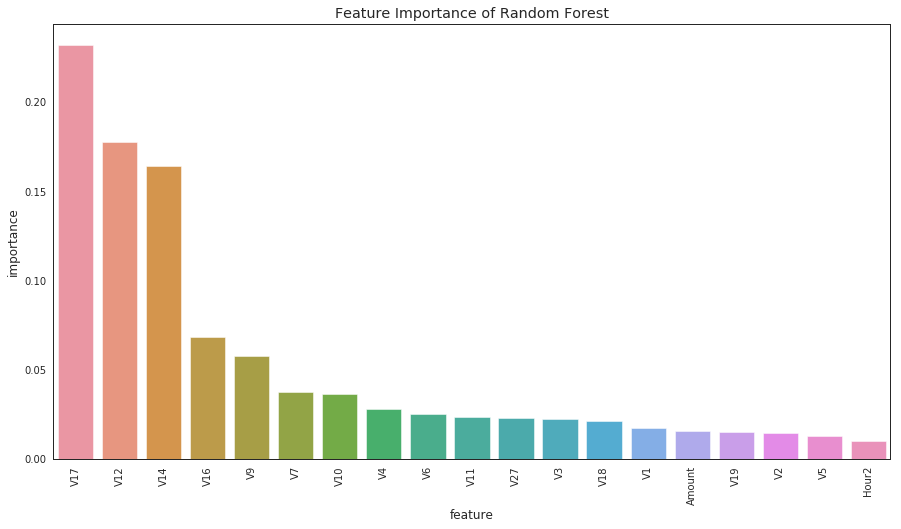

In [32]:
impor = pd.DataFrame({
    'feature': X_feature,
    'importance': rf.feature_importances_
})

impor = impor.sort_values('importance', ascending = False)

fig, axes = plt.subplots(figsize = (15,8))
sns.barplot(x = 'feature', y = 'importance', data = impor)
plt.xticks(rotation = 90)
plt.title('Feature Importance of Random Forest')
plt.show()

### Model

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3f}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

### Without Sampling

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state = 123)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

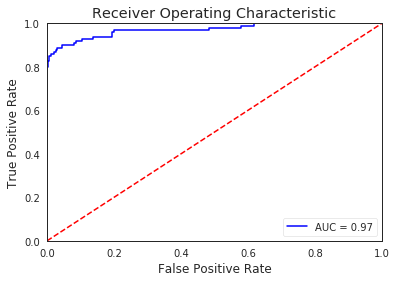

In [35]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

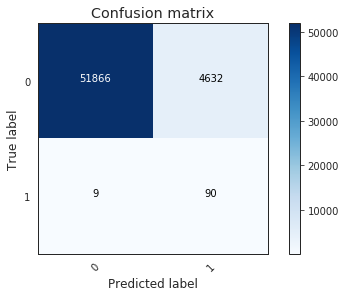

Precision =     0.019
Recall (TPR) =  0.909
Fallout (FPR) = 0.082


In [36]:
thresh = 0.001
y_pred = [1 if x > thresh else 0 for x in probs[:,1]]
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

### With Sampling

In [37]:
sm = SMOTE(random_state = 42)

X_smote, y_smote = sm.fit_sample(X_train, y_train)

print("After SMOTE to balance pos and neg cases:")
print('sample size: {}; Fraud: {:.2%}; Valid: {:.2%}'.format(
    X_smote.shape[0],
    y_smote[y_smote == 1].shape[0] / X_smote.shape[0],
    y_smote[y_smote == 0].shape[0] / X_smote.shape[0]
))

After SMOTE to balance pos and neg cases:
sample size: 452038; Fraud: 50.00%; Valid: 50.00%


#### Logistic Regression

In [38]:
lr1 = LogisticRegression()
lr1.fit(X_smote, y_smote)
y_pred = lr1.predict(X_test)

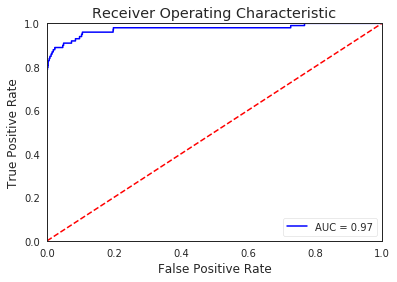

In [39]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr1.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

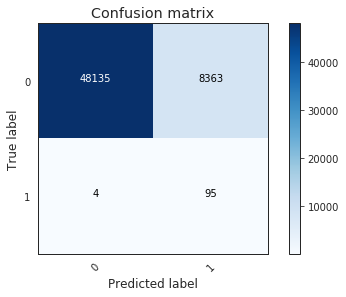

Precision =     0.011
Recall (TPR) =  0.960
Fallout (FPR) = 0.148


In [40]:
thresh = 0.15
y_pred = [1 if x > thresh else 0 for x in probs[:,1]]
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

#### Logistic Regression with regularization

In [41]:
from sklearn.model_selection import GridSearchCV

# Use L1 and L2 regularization to prevent overfitting
param_grid = {
    'C': np.linspace(1,10,10),
    'penalty':['l1','l2']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid_search.fit(X_smote, y_smote)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [42]:
results = pd.DataFrame(grid_search.cv_results_)
best = np.argmax(results.mean_test_score.values)

print('Best Parameter:{}'.format(grid_search.best_params_))
print('Best cross-validation score: {:.5f}'.format(grid_search.best_score_))

Best Parameter:{'C': 1.0, 'penalty': 'l1'}
Best cross-validation score: 0.93833


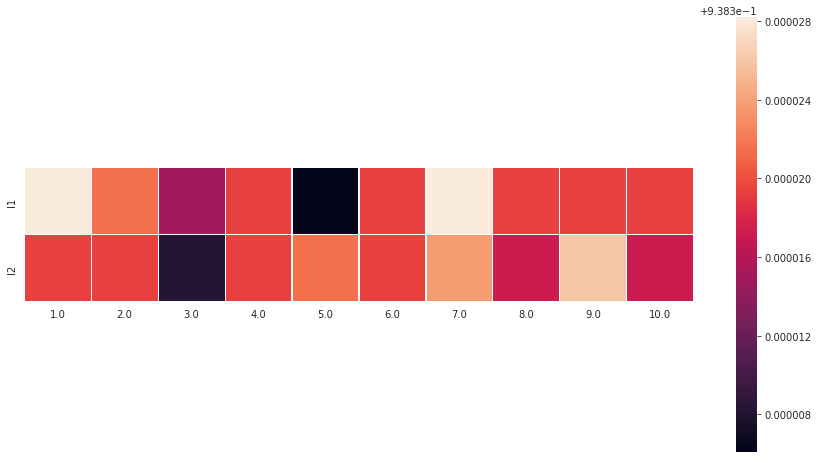

In [43]:
plt.figure(figsize = (15,8))
scores = np.array(results.mean_test_score).reshape(2,10)
sns.heatmap(scores, yticklabels = param_grid['penalty'], xticklabels = param_grid['C'], linewidths = 0.1, square = True)
plt.show()

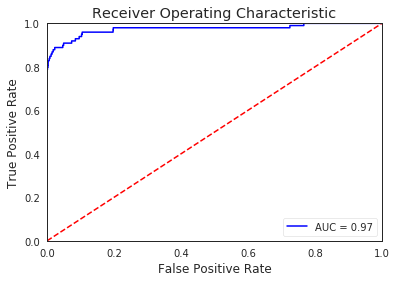

In [44]:
# calculate the fpr and tpr for all thresholds of the classification
probs = grid_search.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

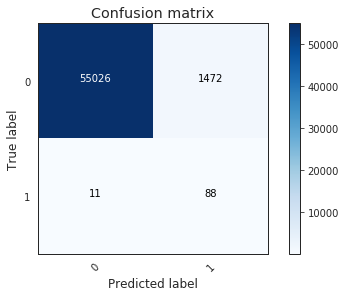

Precision =     0.056
Recall (TPR) =  0.889
Fallout (FPR) = 0.026


In [45]:
thresh = 0.5
y_pred = [1 if x > thresh else 0 for x in probs[:,1]]
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

In [46]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99     56498
          1       0.06      0.89      0.11        99

avg / total       1.00      0.97      0.99     56597



#### Gradient Boosting Model

In [47]:
from sklearn import ensemble
params = {'n_estimators':500, 'max_depth':3, 'subsample':0.5,
         'learning_rate':0.1, 'min_samples_leaf':1, 'random_state':3}

ens = ensemble.GradientBoostingClassifier(**params)
ens.fit(X_smote, y_smote)

y_pred = ens.predict(X_test)

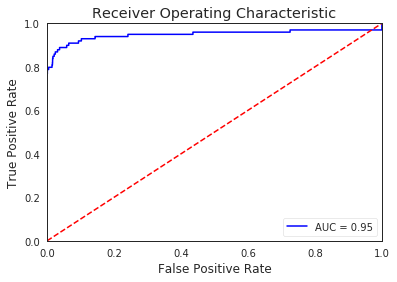

In [48]:
# calculate the fpr and tpr for all thresholds of the classification
probs = ens.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

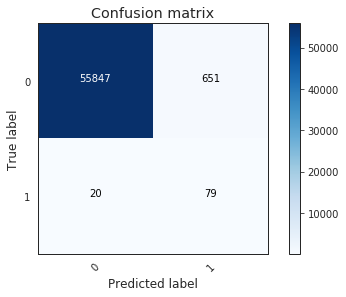

Precision =     0.108
Recall (TPR) =  0.798
Fallout (FPR) = 0.012


In [49]:
thresh = 0.1
y_pred = [1 if x > thresh else 0 for x in probs[:,1]]
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

### Anomaly Detetction Model

In [50]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [51]:
# DEFINE A RANDOM STATE
state = 1

# define the outlier detection method
classifier = {
    'Isolation Forest': IsolationForest(max_samples = len(X),
                                       contamination = outlier_fraction,
                                       random_state = state),
    'Local Outlier Factor': LocalOutlierFactor(n_neighbors = 20,
                                              contamination = outlier_fraction)
}

In [52]:
# Fit the model
n_outliers = len(fraud)

for i, (clf_name,clf) in enumerate(classifier.items()):
    
    # fit the data and tag outliers
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
        
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    # Reshape the prediction values to 0 for valid, 1 for fraud
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != y).sum()
    
    # Run classication Metrics
    print('{} : {}'.format(clf_name, n_errors))
    print(accuracy_score(y, y_pred))
    print(classification_report(y, y_pred))

Isolation Forest : 546
0.998070548657
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    282517
          1       0.42      0.44      0.43       465

avg / total       1.00      1.00      1.00    282982

Local Outlier Factor : 954
0.99662876084
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    282517
          1       0.00      0.00      0.00       465

avg / total       1.00      1.00      1.00    282982



 ### Choosing the best model
 

Recall metric in the testing dataset:  0.979797979798


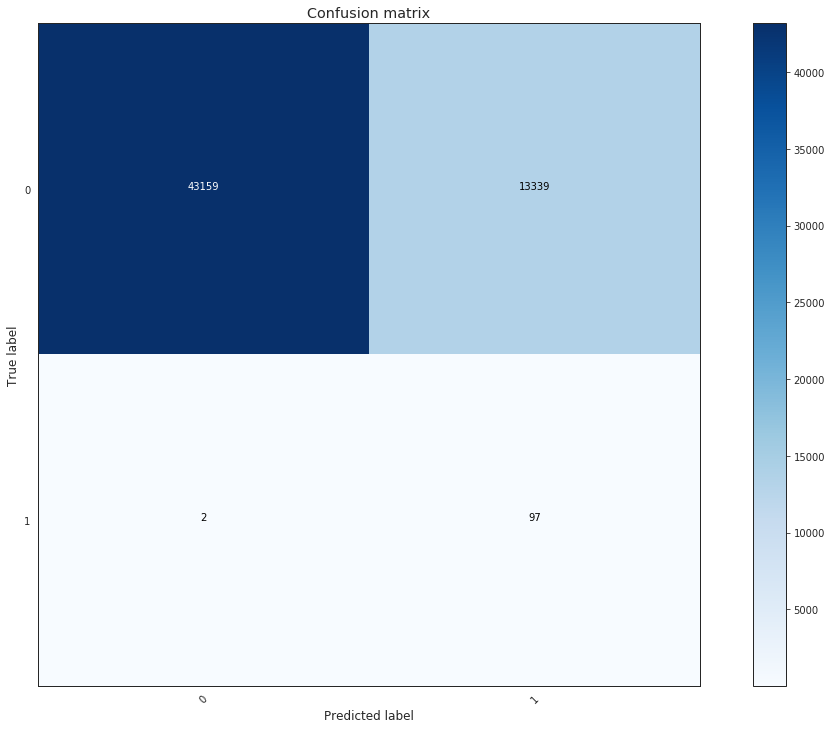

Recall metric in the testing dataset:  0.939393939394


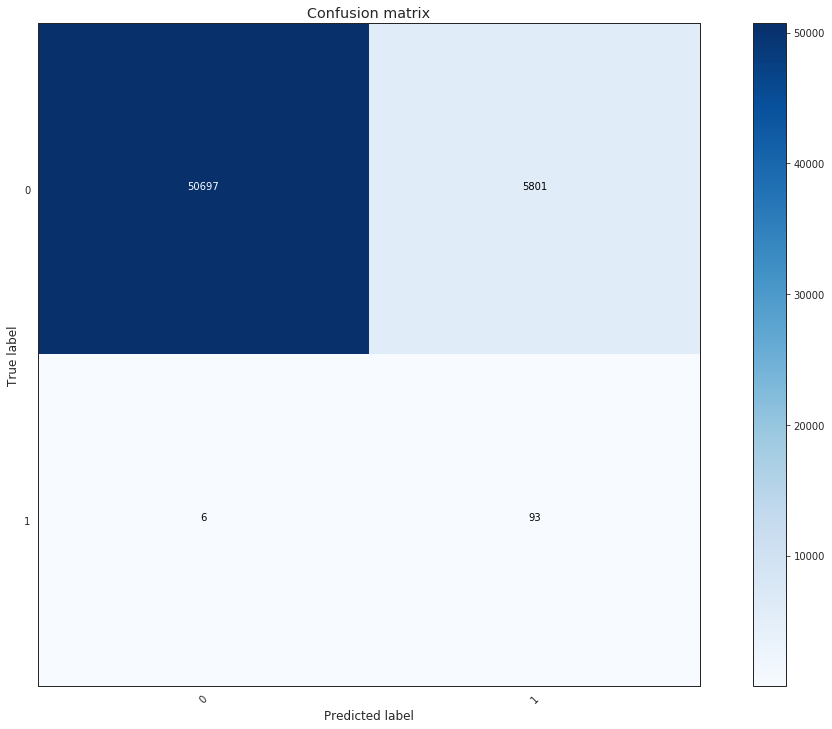

Recall metric in the testing dataset:  0.909090909091


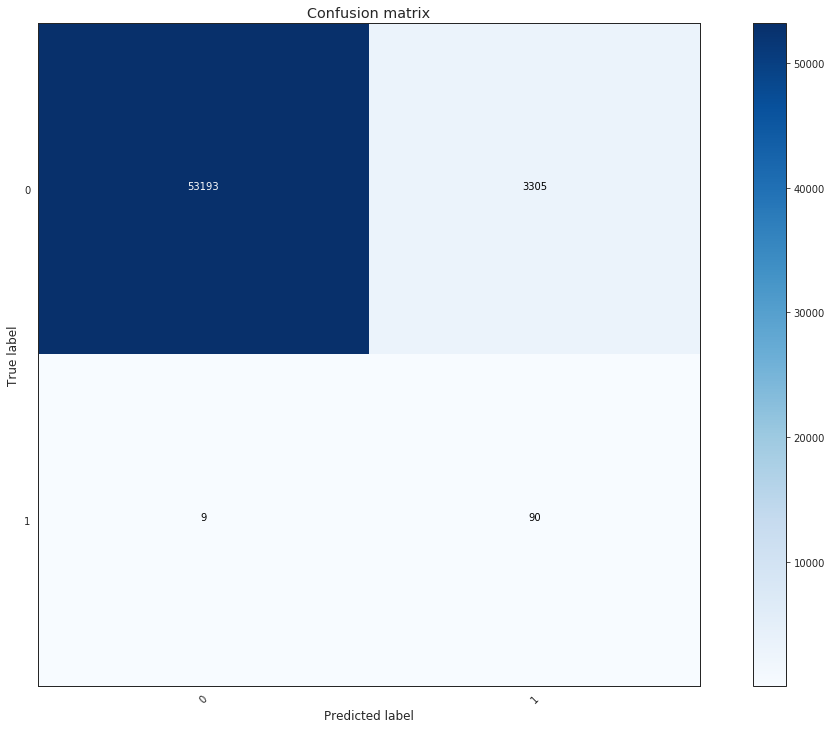

Recall metric in the testing dataset:  0.888888888889


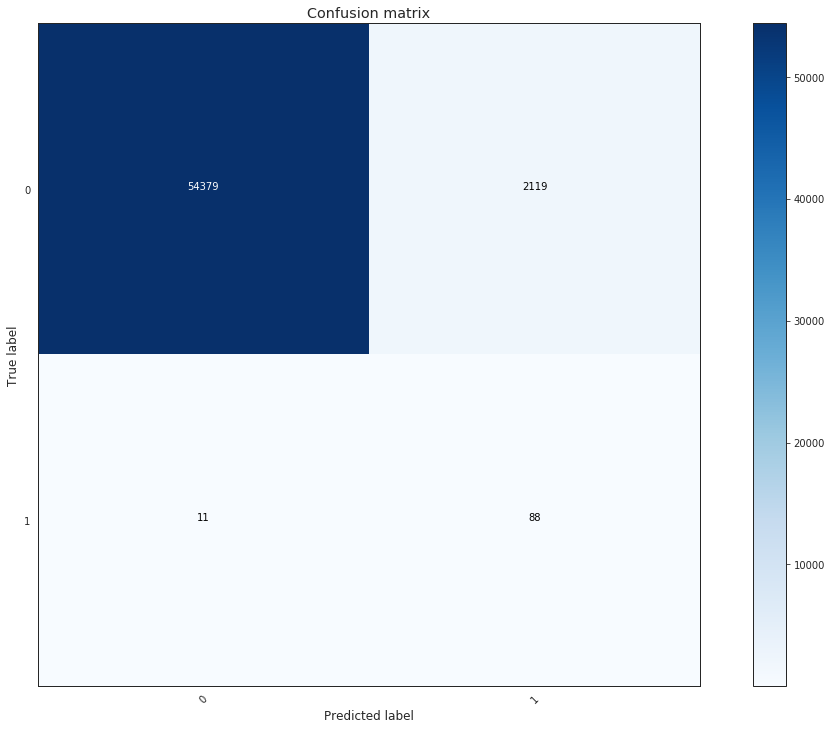

Recall metric in the testing dataset:  0.888888888889


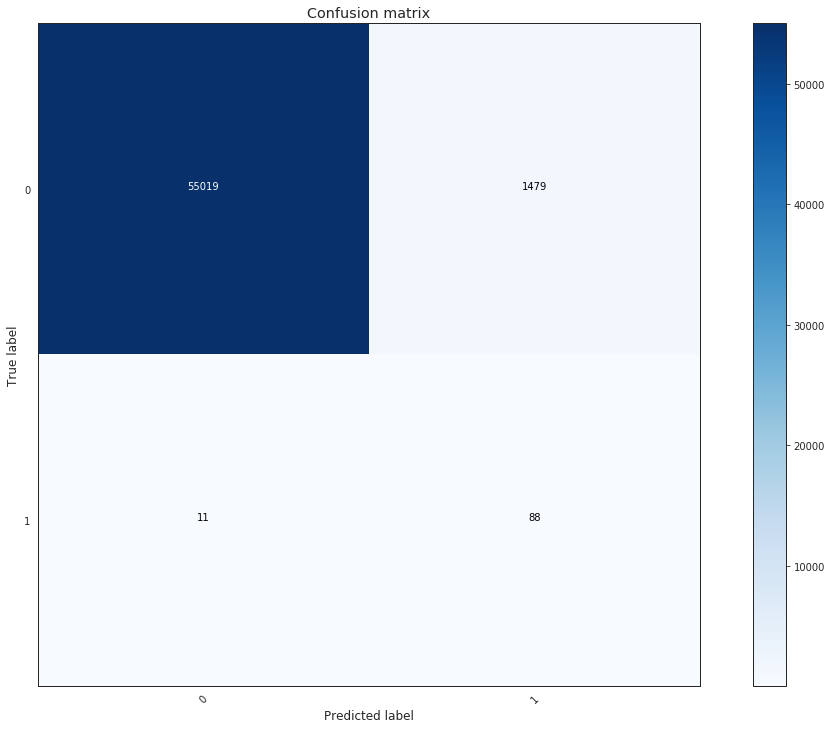

Recall metric in the testing dataset:  0.878787878788


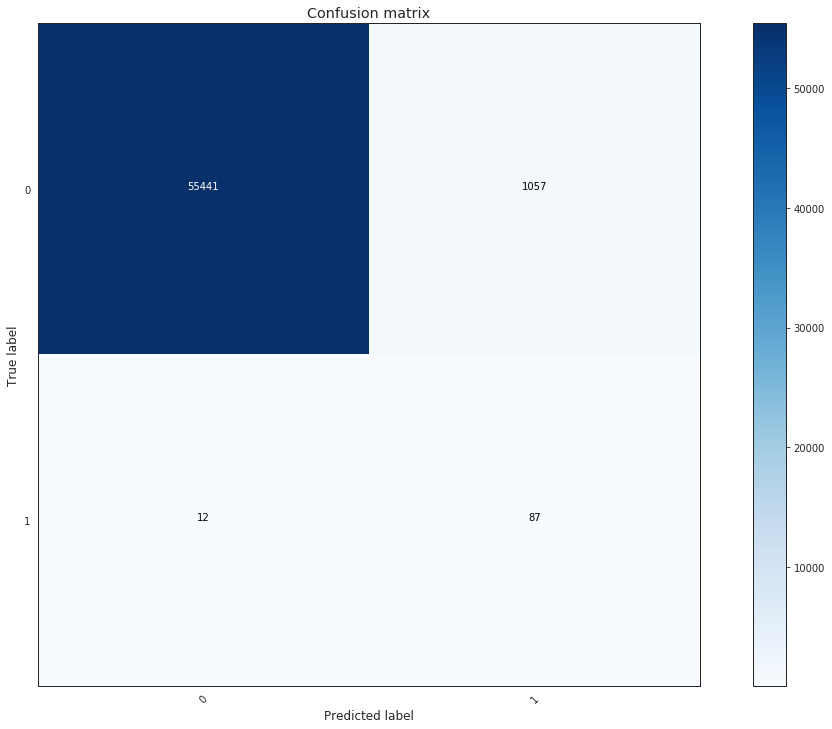

Recall metric in the testing dataset:  0.858585858586


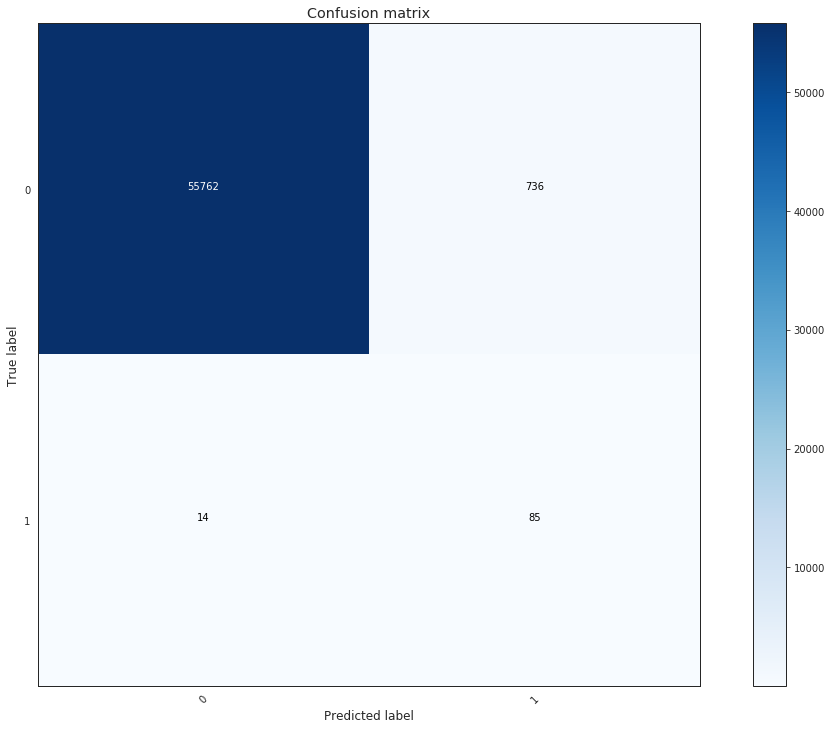

Recall metric in the testing dataset:  0.848484848485


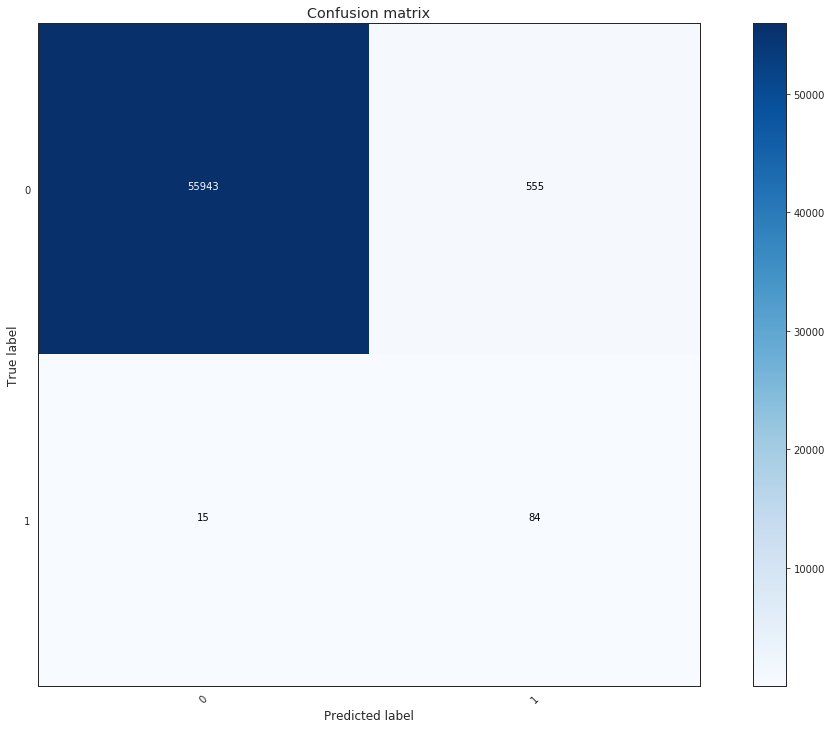

Recall metric in the testing dataset:  0.828282828283


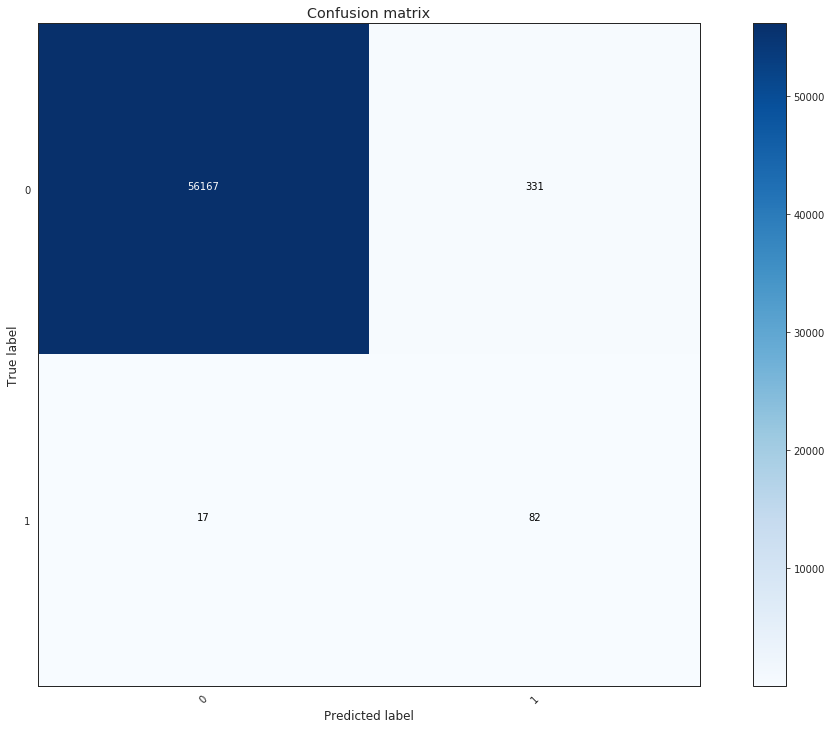

In [53]:
y_pred_proba = lr1.predict_proba(X_test)  #predict_prob 

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]  

for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] > i
    
    plt.figure(figsize=(15,10))
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names)

    
plt.show()    

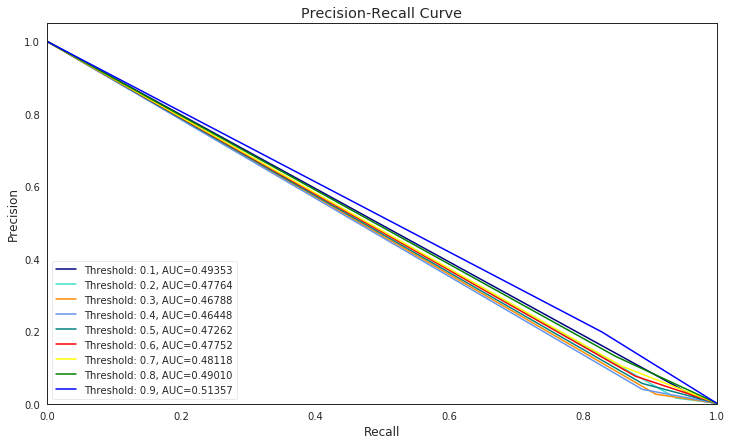

In [54]:
from itertools import cycle

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(12,7))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_proba[:,1] > i 

    precision, recall, thresholds = precision_recall_curve(y_test, y_test_predictions_prob)
    area = auc(recall, precision)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s, AUC=%0.5f' %(i , area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")